In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [2]:
dados_treino = pd.read_csv("data/train.csv")

dados_treino.head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


# Análise Exploratória

In [3]:
print(dados_treino.describe(), dados_treino.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
                  id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000

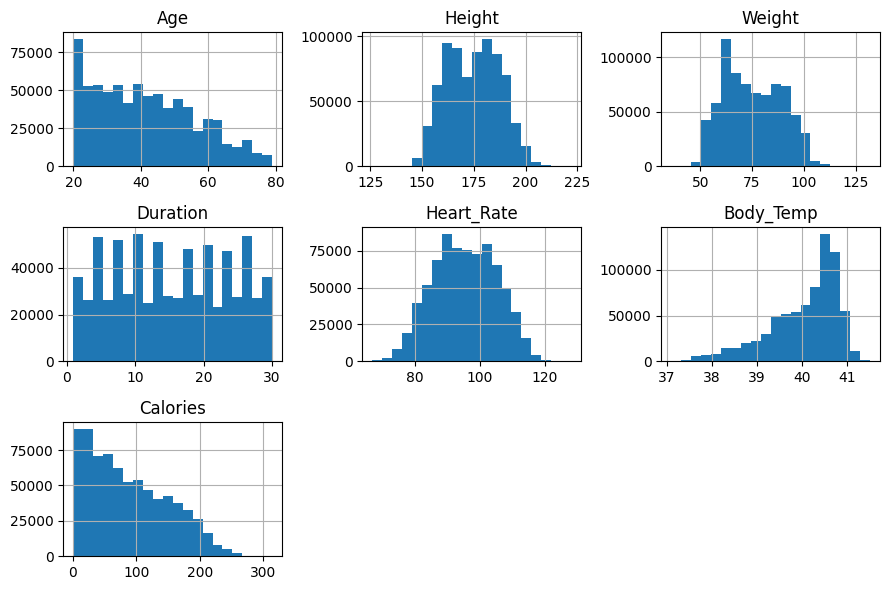

In [4]:
dados_treino.select_dtypes(include="number").drop(columns=["id"]).hist(figsize=(9, 6), bins=20)
plt.tight_layout()
plt.show()

Observa-se que a variável target, **Calories**, apresenta assimetria positiva. Isso exige atenção na escolha da função de perda, pois o RSS atribui maior peso a erros grandes, fazendo com que observações extremas tenham influência desproporcional no ajuste do modelo, o que pode prejudicar a generalização.

Além disso, variáveis com pouca variabilidade tendem a oferecer menos pontos de corte relevantes, podendo ser menos exploradas por modelos baseados em árvores.

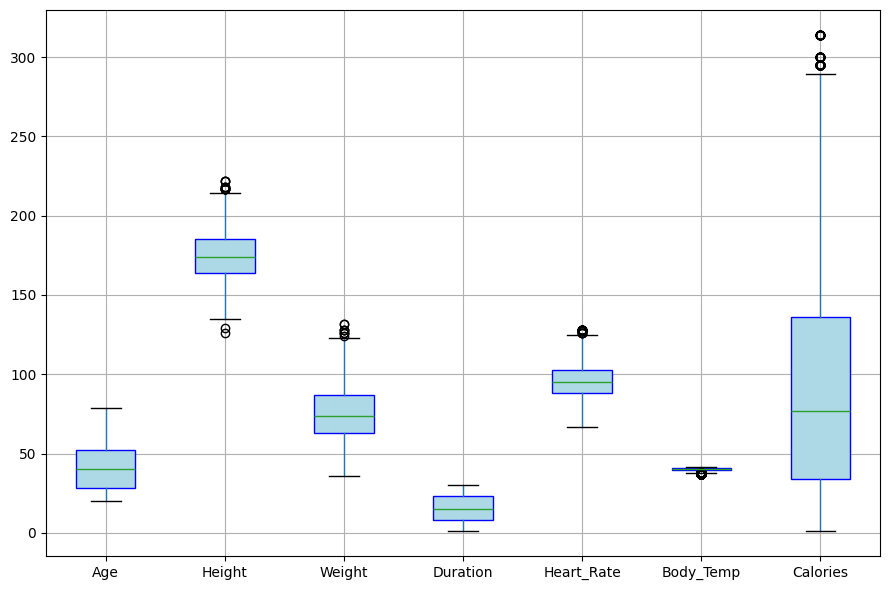

In [5]:
dados_treino.select_dtypes(include="number").drop(columns=["id"]).boxplot(figsize=(9, 6),  patch_artist = True, boxprops = dict(facecolor = "lightblue", color = "blue"))
plt.tight_layout()
plt.show()

**Age** e **Duration** não têm outliers.

Como vimos, **Body_Temp** é pouco distribuído e **Calories** possui uma cauda mais longa em valores maiores, causando uma assimetria positiva na distribuição, o que não é causado por excesso de outliers.

As variáveis **Heart_Rate** e **Weight** possuem outliers mas nada muito absurdo em relação às suas distribuições.

Vamos investigar mais a fundo a distribuição de **Height**, que é a variável mais "problemática" em termos de outliers que vimos.

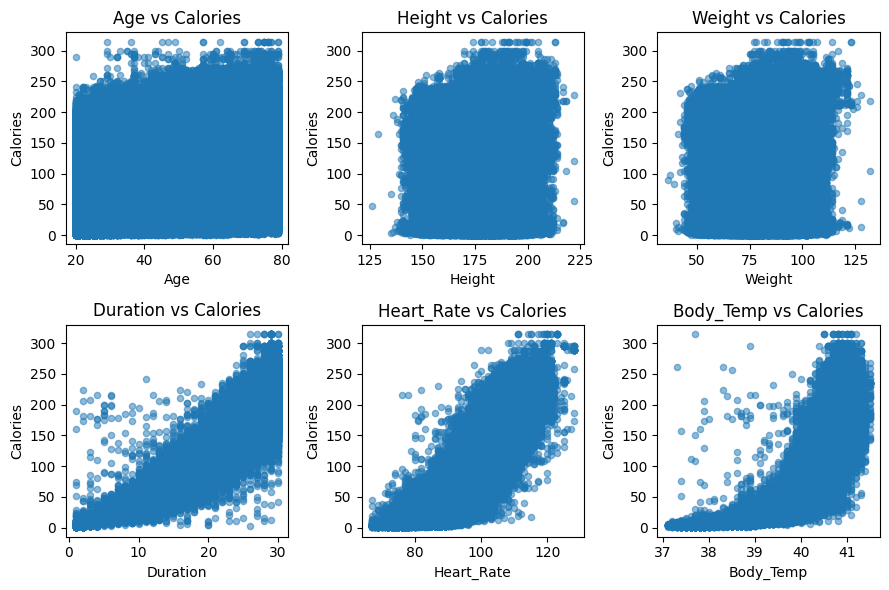

In [6]:
features = dados_treino.select_dtypes(include="number").drop(columns=["id", "Calories"]).columns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.flatten()

for i, col in enumerate(features):
    dados_treino.plot.scatter(x=col, y="Calories", ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{col} vs {"Calories"}")

plt.tight_layout()
plt.show()

Vemos que: **Age**, **Height** e **Weight** têm uma relação quase que uniforme com **Calories**, talvez não sejam as melhores preditoras, para melhor uso delas, talvez possamos ter que criar interações.

**Duration** e **Heart_Rate** têm uma relação extremamente linear pelo que mostram os gráficos, possam ser talvez as preditoras mais fortes. Nesse caso,transformações adicionais provavelmente trariam pouco ganho marginal de desempenho.

**Body_Temp** não parece possuir relação linear, mas sim uma relação exponencial, talvez testar uma transformação logarítimica na variável resposta ou nela mesma possa ajudar a linearizar essa relação.

Como nesse projeto iremos usar dois modelos baseádos em árvores, o fato da relação não linear entre as variáveis preditoras e target, não atrapalharia muito, já que as árvores lidam bem e fazem interação entre as variáveis automaticamente, entretanto, vamos testar o desempenho de **Body_Temp** quando feito a transformação logarítimica. 

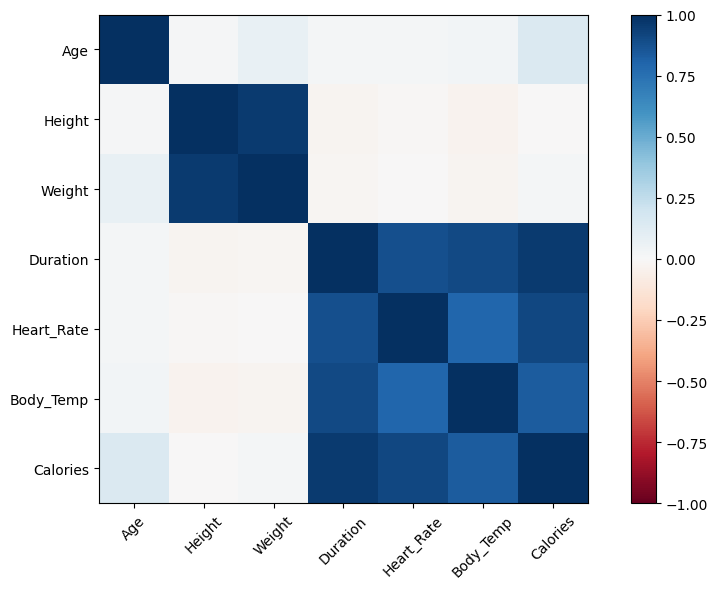

In [ ]:
corr = dados_treino.select_dtypes(include="number").drop(columns=["id"]).corr()

plt.figure(figsize=(9,6))
plt.imshow(corr, cmap="RdBu", vmin=-1, vmax=1)

plt.colorbar()
tick_marks = [i for i in range(len(corr.columns))]
plt.xticks(tick_marks, corr.columns, rotation = 45)
plt.yticks(tick_marks, corr.columns)

plt.tight_layout()

Primeira coisa interessante a se notar é que não existem correlações negativas.

Por intuição, Peso e Altura são altamente correlacionados

**Duration**, **Heart_Rate**, **Body_Temp** e **Calories** são todas extremamente correlacionadas também

Essas 4 variáveis correlacionadas, foram vistas no gráfico anterior, apontamos com ele a relação forte que elas tinham com a preditora, vimos agora a relação forte que têm entre si, também.

Um caso interessante a se notar, é que **Body_Temp** é altamente correlacionado com **Calories**, no gráfico anteriro vimos uma relação não linear, sabemos que correlação mede justamente a correlação linear entre variáveis. Isso ocorre porque a correlação de Pearson mede apenas associação linear, e ainda assim pode ser elevada quando há uma relação monotônica forte. Vimos também que sua distribuição é pouco dispersa, concentrada mais em sua mediana, tendo assim, pouca variabilidade, por intuição, variáveis dessa natureza possuem baixa variância, o que dificulta splits em modelos de árvore.

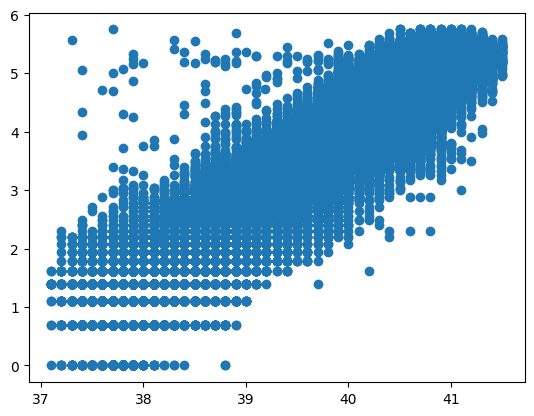

In [8]:
log_cal_treino = np.log(dados_treino["Calories"])
plt.scatter(x=dados_treino["Body_Temp"], y = log_cal_treino)

Esse gráfico comprova nossa tese, a transformação logarítimica ajusta linearidade em **Body_Temp**.

Para o modelo, podemos testar com **Calories** transformada e não transformada.

## Explicações acerca das relações das variáveis

O gasto calórico durante o exercício está diretamente ligado ao consumo de oxigênio, que aumenta conforme a frequência cardíaca, explicando a relação quase linear entre **Heart_Rate** e **Calories**. A variável Duration também apresenta forte relação com o gasto calórico, já que a energia consumida é acumulada ao longo do tempo.

A temperatura corporal se eleva como consequência da ineficiência dos processos metabólicos, nos quais parte da energia é dissipada em forma de calor. Como esse aumento ocorre com atraso em relação ao esforço físico, a relação entre **Body_Temp** e **Calories** tende a ser não linear.

Já variáveis como **Age**, **Height** e **Weight** têm pouca relação direta com o gasto calórico durante a atividade em si, influenciando mais o metabolismo basal do que o consumo energético imediato do exercício.

(array([0, 1]), [Text(0, 0, 'female'), Text(1, 0, 'male')])

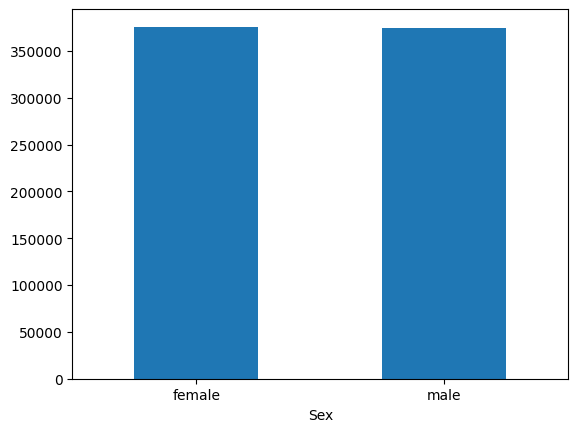

In [9]:
dados_treino["Sex"].value_counts().plot(kind = "bar")
plt.xticks(rotation = 0)

A população masculina e feminina aparecem praticamente na mesma quantidade.

Vamos ver se existe relação no gasto calórico para a amostra feminina e para masculina

/tmp/ipykernel_22680/362102691.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kcal_fem_treino, kcal_mas_treino], labels = ["Feminino", "Masculino"], positions=[1,2], patch_artist = True, boxprops = dict(facecolor = "lightblue", color = "blue"))
/tmp/ipykernel_22680/362102691.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


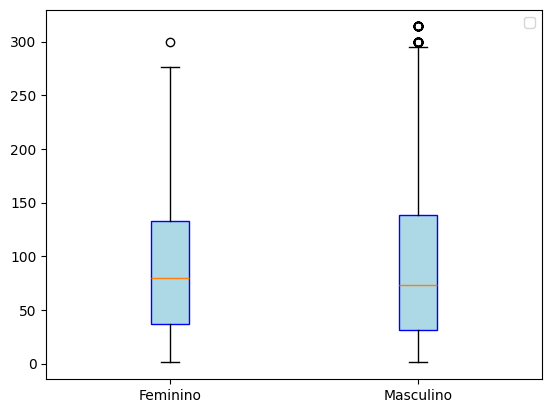

In [10]:
kcal_fem_treino = dados_treino[dados_treino["Sex"] == "female"]["Calories"]
kcal_mas_treino = dados_treino[dados_treino["Sex"] == "male"]["Calories"]

plt.boxplot([kcal_fem_treino, kcal_mas_treino], labels = ["Feminino", "Masculino"], positions=[1,2], patch_artist = True, boxprops = dict(facecolor = "lightblue", color = "blue"))

plt.legend()

A mediana do gasto calórico feminino parece ser ligeiramente maior que o masculino, porém o gasto masculino se alonga mais para valores maiores, tendo maior dispersão, ou assimetria positiva e mais valores extremos.

Para ter certeza absoluta podemos rodar um teste estatístico, como vimos que a distribuição calórica parece ser log-normal, ou transformamos em escala logarítimica ou usamos um teste não paramétrico.

Vamos usar o teste não paramétrico para amostras independentes Mann-Whitney U.

In [11]:
print(f"P-valor: {mannwhitneyu(kcal_fem_treino, kcal_mas_treino, alternative="two-sided").pvalue}",
      "\n--------------------",
      f"\nGasto Feminino: Média = {kcal_fem_treino.mean().round()} e Mediana = {kcal_fem_treino.median()}",
      f"\nGasto Masculino: Média = {kcal_mas_treino.mean().round()} e Mediana = {kcal_mas_treino.median()}")

P-valor: 2.2695346394599062e-29 
-------------------- 
Gasto Feminino: Média = 88.0 e Mediana = 80.0 
Gasto Masculino: Média = 89.0 e Mediana = 73.0


Como o P-valor é extremamente baixo p < 0.05, rejeitamos a hipótese nula e confirmamos que existe uma diferença estatisticamente significativa entre os grupos. Baseando-se na comparação das medianas, podemos afirmar que o gasto calórico feminino tende a ser superior ao masculino.

## Pequena Investigação

Agora pouco importa pro desempenho do modelo, vamos entender o porquê o gasto feminino é maior que o masculino.

Sabemos que as únicas variáveis correlacionadas com gasto calórico são: **Duration**, **Heart_Rate** e **Body_Temp**, então precisamos entender se existe uma correlação da variável **Sex** com essas outras, se o grupo feminino treinou em média por mais tempo, se fizeram exercícios mais intensos para aumentar frequência cardíaca, ou se esquentaram mais.

In [12]:
# Para Duration

duration_fem_treino = dados_treino[dados_treino["Sex"] == "female"]["Duration"]
duration_mas_treino = dados_treino[dados_treino["Sex"] == "male"]["Duration"]


print(f"P-valor: {mannwhitneyu(duration_fem_treino, duration_mas_treino, alternative="two-sided").pvalue}",
      "\n----------------------------",
      f"\nDuração Feminino: Média = {duration_fem_treino.mean().round()} e Mediana = {duration_fem_treino.median()}",
      f"\nDuração Masculino: Média = {duration_mas_treino.mean().round()} e Mediana = {duration_mas_treino.median()}",
      "\n----------------------------")

# Para Heart_Rate

fc_fem_treino = dados_treino[dados_treino["Sex"] == "female"]["Heart_Rate"]
fc_mas_treino = dados_treino[dados_treino["Sex"] == "male"]["Heart_Rate"]


print(f"\nP-valor: {mannwhitneyu(fc_fem_treino, fc_mas_treino, alternative="two-sided").pvalue}",
      "\n----------------------------",
      f"\nFrequência Cardíaca Feminina: Média = {fc_fem_treino.mean().round()} e Mediana = {fc_fem_treino.median()}",
      f"\nFrequência Cardíaca Masculina: Média = {fc_mas_treino.mean().round()} e Mediana = {fc_mas_treino.median()}",
      "\n----------------------------")

# Para Body_Temp

temp_fem_treino = dados_treino[dados_treino["Sex"] == "female"]["Body_Temp"]
temp_mas_treino = dados_treino[dados_treino["Sex"] == "male"]["Body_Temp"]


print(f"\nP-valor: {mannwhitneyu(temp_fem_treino, temp_mas_treino, alternative="two-sided").pvalue}",
      "\n----------------------------",
      f"\nTemperatura Corporal Feminina: Média = {temp_fem_treino.mean().round()} e Mediana = {temp_fem_treino.median()}",
      f"\nTemperatura Corporal Masculina: Média = {temp_mas_treino.mean().round()} e Mediana = {temp_mas_treino.median()}",
      "\n----------------------------")

P-valor: 1.3396942244180752e-17 
---------------------------- 
Duração Feminino: Média = 16.0 e Mediana = 16.0 
Duração Masculino: Média = 15.0 e Mediana = 15.0 
----------------------------

P-valor: 1.5447430993640376e-06 
---------------------------- 
Frequência Cardíaca Feminina: Média = 95.0 e Mediana = 96.0 
Frequência Cardíaca Masculina: Média = 96.0 e Mediana = 95.0 
----------------------------

P-valor: 1.1905208304139953e-15 
---------------------------- 
Temperatura Corporal Feminina: Média = 40.0 e Mediana = 40.3 
Temperatura Corporal Masculina: Média = 40.0 e Mediana = 40.2 
----------------------------


Como o p-valor é extremamente baixo (p < 0.05), rejeitamos a hipótese nula de igualdade entre os grupos e confirmamos que existe uma diferença estatisticamente significativa na duração dos exercícios entre os sexos.
Com base na comparação das medianas, o grupo feminino apresenta duração ligeiramente maior que o masculino.

Repetindo a análise para as demais variáveis, observamos também diferenças estatisticamente significativas para frequência cardíaca e temperatura corporal, com medianas ligeiramente maiores no grupo feminino, possivelmente associadas a exercícios realizados com maior intensidade.

No entanto, apesar da significância estatística, as diferenças absolutas entre médias e medianas são muito pequenas, especialmente para temperatura corporal. Em conjuntos de dados grandes, mesmo diferenças mínimas podem gerar p-valores extremamente baixos, sem que isso represente necessariamente um efeito prático relevante.

Portanto, podemos afirmar que houve diferenças no padrão de coleta entre os grupos (duração, frequência cardíaca e temperatura), o que ajuda a explicar parte da diferença observada no gasto calórico. Entretanto, não é possível concluir que o sexo, por si só, seja a causa direta da diferença no gasto calórico, mas sim que ele atua como uma variável associada a diferentes padrões de exercício neste conjunto de dados.

## Conclusões Gerais EDA

Nossas variáveis mais importantes para a construção do modelo provavelmente são: 
 - **Duration**
 - **Heart_Rate**
 - **Body_Temp**

Com **Body_Temp** tendo uma relação exponencial com **Calories**, podemos testar o modelo com a target log-transformada.

As outras variáveis fisiológicas não possuem grande relação linear e nem correlação com a variável target.

A variável target **Calories** possui distribuição que se assemelha à log-normal, com assimetria positiva, não causada por outliers.

Os "problemas" encontrados em relação à distribuições e etc, não são tão preocupantes para modelos baseados em árvores, pois estes não são geométricos ou lineares, só temos que ficar de olho para evitar que as árvores splitem mais que necessário para explicar alguns dados da cauda mais longa de **Calories** ignorando os dados das medidas centrais, causando um overfit e mau desempenho no modelo. 

A assimetria pode ser resolvida usando o mesmo loss function que o evaluation da competição, que é o RMSLE, ou log transformar a target e usar MSE.

Portanto, embora transformações e tratamentos de distribuição não sejam estritamente necessários para modelos de árvore, podem ser explorados em etapas posteriores caso seja necessário otimizar ainda mais o desempenho do modelo.

# Modelagem

Vamos criar as funções dos modelos RandomForest e GBoost, usando loss function como MSE

In [43]:
def RandomForest(X, Y, n_estimators=100, min_frac=0.005, m_try=None):

    rng = np.random.default_rng()

    if m_try is None:
        m_try = int(np.sqrt(X.shape[1]))

    N_TOTAL = len(Y)
    trees = []

    # ================= LOSS DO SPLIT =================

    def RSS(Y1, Y2):
        return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()

    # ================= MELHOR CORTE =================

    def Knot(X_col, Y):
        if len(X_col) < 2:
            return {"s_selected": None, "error": np.inf}

        idx = np.argsort(X_col)
        Xs = X_col[idx]
        Ys = Y[idx]

        s = (Xs[:-1] + Xs[1:]) / 2
        errors = np.zeros(len(s))

        for i in range(len(s)):
            mask = Xs < s[i]
            Y1 = Ys[mask]
            Y2 = Ys[~mask]

            errors[i] = RSS(Y1, Y2)

        m = np.argmin(errors)
        return {"s_selected": s[m], "error": errors[m]}

    # ================= SELEÇÃO DE VARIÁVEL =================

    def Select_var(X, Y):
        p = X.shape[1]
        vars_idx = rng.choice(p, size=m_try, replace=False)

        best_s = None
        best_var = None
        best_error = np.inf

        for i in vars_idx:
            res = Knot(X[:, i], Y)
            if res["error"] < best_error:
                best_error = res["error"]
                best_s = res["s_selected"]
                best_var = i

        mask = X[:, best_var] < best_s

        return Y[mask], Y[~mask], X[mask], X[~mask], best_var, best_s

    # ================= CONSTRUÇÃO DA ÁRVORE =================

    def Build_Tree(X, Y):

        # parada por tamanho
        if len(Y) < min_frac * N_TOTAL:
            return {"leaf": True, "value": Y.mean()}

        R1, R2, X_R1, X_R2, var_idx, cutpoint = Select_var(X, Y)

        # parada se split ruim
        if len(R1) < min_frac * len(Y) or len(R2) < min_frac * len(Y):
            return {"leaf": True, "value": Y.mean()}

        left = Build_Tree(X_R1, R1)
        right = Build_Tree(X_R2, R2)

        return {
            "leaf": False,
            "var": var_idx,
            "cut": cutpoint,
            "left": left,
            "right": right
        }

    # ================= PREDIÇÃO =================

    def predict_tree(node, x_new):
        if node["leaf"]:
            return node["value"]
        if x_new[node["var"]] < node["cut"]:
            return predict_tree(node["left"], x_new)
        else:
            return predict_tree(node["right"], x_new)

    def predict_forest(X_new):
        preds = np.zeros((len(X_new), len(trees)))

        for j, tree in enumerate(trees):
            for i in range(len(X_new)):
                preds[i, j] = predict_tree(tree, X_new[i])

        # média das árvores
        return preds.mean(axis=1)

    # ================= BOOTSTRAP + TREINO =================

    for _ in range(n_estimators):
        idx = rng.choice(len(Y), len(Y), replace=True)
        Xb = X[idx]
        Yb = Y[idx]

        tree = Build_Tree(Xb, Yb)
        trees.append(tree)

    return trees, predict_forest

def GradientBoosting(X, Y, n_estimators=100, learning_rate=0.1, min_frac=0.05, max_depth = 1):

    rng = np.random.default_rng()

    N_TOTAL = len(Y)
    y_mean = Y.mean()

     # ================= LOSS DO SPLIT =================

    def RSS(Y1, Y2):
        return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()


    # =================== MELHOR CORTE =================

    def Knot(X_col, Y):
        if len(X_col) < 2:
            return {"s_selected": None, "error": np.inf}

        idx = np.argsort(X_col)
        Xs = X_col[idx]
        Ys = Y[idx]

        s = (Xs[:-1] + Xs[1:]) / 2
        errors = np.zeros(len(s))

        for i in range(len(s)):
            mask = Xs < s[i]
            Y1 = Ys[mask]
            Y2 = Ys[~mask]
            errors[i] = RSS(Y1, Y2)

        m = np.argmin(errors)
        return {"s_selected": s[m], "error": errors[m]}


    # ============= SELEÇÃO DA MELHOR VARIÁVEL ===============

    def Select_var(X, Y):
        best_s = None
        best_var = None
        best_error = np.inf

        for i in range(X.shape[1]):
            res = Knot(X[:, i], Y)
            if res["error"] < best_error:
                best_error = res["error"]
                best_s = res["s_selected"]
                best_var = i

        mask = X[:, best_var] < best_s

        return Y[mask], Y[~mask], X[mask], X[~mask], best_var, best_s


    # ================== CONSTRUÇÃO DA ÁRVORE ==================

    def Build_Tree(X, Y, depth = 0):

        # Parada por tamanho mínimo do nó
        if len(Y) < min_frac * N_TOTAL or depth >= max_depth:
            return {"leaf": True, "value": Y.mean()}

        R1, R2, X_R1, X_R2, var_idx, cutpoint = Select_var(X, Y)

        # Parada se split ruim
        if len(R1) < min_frac * len(Y) or len(R2) < min_frac * len(Y):
            return {"leaf": True, "value": Y.mean()}

        left = Build_Tree(X_R1, R1, depth + 1)
        right = Build_Tree(X_R2, R2, depth + 1)

        return {
            "leaf": False,
            "var": var_idx,
            "cut": cutpoint,
            "left": left,
            "right": right
        }

   
    #  ================= PREDIÇÃO DE UMA ÁRVORE ===============
 
    def predict_tree(node, x_new):
        if node["leaf"]:
            return node["value"]
        if x_new[node["var"]] < node["cut"]:
            return predict_tree(node["left"], x_new)
        else:
            return predict_tree(node["right"], x_new)

    def predict_tree_batch(tree, X_new):
        return np.array([predict_tree(tree, x) for x in X_new])


    #  ================= TREINAMENTO DO BOOSTING ==================

    F = np.full(len(Y), y_mean)   # modelo inicial (constante)
    models = []
    train_mse = []

    for m in range(n_estimators):

        # pseudo-resíduos (gradiente do MSE)
        r = Y - F

        tree = Build_Tree(X, r)
        models.append(tree)

        F += learning_rate * predict_tree_batch(tree, X)

        mse = np.mean((Y - F) ** 2)
        train_mse.append(mse)


    #  ========================= PREDIÇÃO ============================

    def predict(X_new):
        F_new = np.full(len(X_new), y_mean)
        for tree in models:
            F_new += learning_rate * predict_tree_batch(tree, X_new)
        return F_new

    return {
        "predict": predict,
        "models": models,
        "train_mse": train_mse,
        "y_mean": y_mean,
        "learning_rate": learning_rate
    }


def RMSE(Y, Y_pred):
    return np.sqrt(np.mean((np.log1p(Y_pred) - np.log1p(Y))**2))



Com as funções de ajuste do modelo a avaliação final criadas, vamos dividir os dados em 15/85 (por motivos de poder computacional, já que nossa função tem complexidade O(p.n²) levaria uma eternidade treinar os dados com divisões comuns) e depois ajustar o modelo.

Para o split de dados treino/teste, podemos usar uma amostragem aleatória simples, já que não tem nenhum estrato que evidencia os dados mais que outros. 

In [65]:
dados_treino["Sex_Dummy"] = np.where(dados_treino["Sex"] == "male", 1, 0) # 1 P/ masculino, 0 P/ feminino
treino = dados_treino.drop(columns=["id", "Sex"]).sample(frac = .15, random_state=27)
teste = dados_treino.drop(columns=["id", "Sex"]).drop(treino.index)

treino.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_Dummy
309559,62,182.0,82.0,7.0,89.0,39.6,34.0,0
511493,36,169.0,73.0,7.0,91.0,39.3,32.0,0
67851,28,190.0,93.0,2.0,85.0,38.0,8.0,1
728655,41,167.0,62.0,18.0,98.0,40.4,99.0,0
137667,45,182.0,84.0,9.0,94.0,39.7,44.0,1


Por poder computacional, vamos treinar uma subamostra com grid-search, achar os melhores hiperparâmetros e treinar uma vez com todos os dados.

In [18]:
sub_treino = treino.sample(frac= .01, random_state=27)
sub_teste = teste.sample(frac= .01, random_state=27)

sub_treino.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_Dummy
352009,72,164.0,63.0,6.0,79.0,39.4,24.0,0
148557,53,163.0,58.0,29.0,115.0,40.7,220.0,0
12302,68,158.0,58.0,22.0,111.0,40.7,163.0,0
674589,30,176.0,65.0,14.0,98.0,40.0,75.0,0
67529,27,154.0,55.0,28.0,101.0,40.7,153.0,0


In [ ]:
grid_rf = {
    "n_estimator": [10, 30, 50],
    "min_frac": [0.001 ,0.005, 0.01],
    "learning_rate": [None, 2, 6]
}

results_rf = []

for n in grid_rf["n_estimator"]:
    for mf in grid_rf["min_frac"]:
        for mt in grid_rf["m_try"]:
            
            trees, predict = RandomForest(sub_treino.drop(columns = ["Calories"]).to_numpy(),
                                       np.log(sub_treino["Calories"].to_numpy()),
                                         n_estimators=n,
                                         min_frac=mf,
                                         m_try=mt)
            
            Y_pred = np.exp(predict(sub_teste.drop(columns = ["Calories"]).to_numpy()))
            rmse = RMSE(sub_teste["Calories"].to_numpy(), Y_pred)
            
            results_rf.append({
                "n_estimator": n,
                "min_frac": mf,
                "m_try": mt,
                "rmse": rmse
            })

          

/tmp/ipykernel_22680/3701738109.py:14: RuntimeWarning: Mean of empty slice
  return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()
/home/kau/Documentos/ML-from-scratch-kaggle/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_22680/3701738109.py:14: RuntimeWarning: Mean of empty slice
  return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()
/home/kau/Documentos/ML-from-scratch-kaggle/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_22680/3701738109.py:14: RuntimeWarning: Mean of empty slice
  return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()
/home/kau/Documentos/ML-from-scratch-kaggle/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  

In [ ]:
best_rf = min(results_rf, key=lambda x: x["rmse"])
best_rf

{'n_estimator': 30,
 'min_frac': 0.001,
 'm_try': 6,
 'rmse': np.float64(0.08854095759366429)}

Depois de quase 1h, conseguimos nosso resultado.

Vamos repetir o processo utilizando GBoost

In [50]:
grid_gb = {
    "n_estimator": [150, 200],
    "min_frac": [0.005],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4]
}

results_gb = []

for n in grid_gb["n_estimator"]:
    for mf in grid_gb["min_frac"]:
        for lr in grid_gb["learning_rate"]:
            for mp in grid_gb["max_depth"]:
            
                gb_model = GradientBoosting(sub_treino.drop(columns = ["Calories"]).to_numpy(),
                                        np.log(sub_treino["Calories"].to_numpy()),
                                            n_estimators=n,
                                            min_frac=mf,
                                            learning_rate=lr,
                                            max_depth=mp)
                
                Y_pred = np.exp(gb_model["predict"](sub_teste.drop(columns = ["Calories"]).to_numpy()))
                rmse = RMSE(sub_teste["Calories"].to_numpy(), Y_pred)
                
                results_gb.append({
                    "n_estimator": n,
                    "min_frac": mf,
                    "learning_rate": lr,
                    "max_depth": mp,
                    "rmse": rmse
                })

/tmp/ipykernel_22680/262662763.py:127: RuntimeWarning: Mean of empty slice
  return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()
/home/kau/Documentos/ML-from-scratch-kaggle/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_22680/262662763.py:127: RuntimeWarning: Mean of empty slice
  return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()
/home/kau/Documentos/ML-from-scratch-kaggle/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_22680/262662763.py:127: RuntimeWarning: Mean of empty slice
  return ((Y1 - Y1.mean())**2).sum() + ((Y2 - Y2.mean())**2).sum()
/home/kau/Documentos/ML-from-scratch-kaggle/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  

In [53]:
best_gb = min(results_gb, key=lambda x: x["rmse"])
best_gb

{'n_estimator': 200,
 'min_frac': 0.005,
 'learning_rate': 0.05,
 'max_depth': 4,
 'rmse': np.float64(0.08511548894924248)}

Excelente, conseguimos um valor menor que o do RF.

Vamos treinar os dados finais com esses hiperparâmetros e depois predizer para os dados de teste

In [ ]:
gb_model_final = GradientBoosting(treino.drop(columns = ["Calories"]).to_numpy(),
                                        np.log(treino["Calories"].to_numpy()),
                                            n_estimators=best_gb["n_estimator"],
                                            min_frac=best_gb["min_frac"],
                                            learning_rate=best_gb["learning_rate"],
                                            max_depth   =best_gb["max_depth"])

Y_pred = np.exp(gb_model_final["predict"](teste.drop(columns = ["Calories"]).to_numpy()))

lrmse_treino = np.sqrt(np.array(gb_model_final["train_mse"]).mean())
lrmse_teste = RMSE(teste["Calories"].to_numpy(), Y_pred)


In [74]:
print(f"\nO LRMSE nos dados de teste foi: {lrmse_teste}")


O LRMSE nos dados de teste foi: 0.06802472138446534


Mesmo sendo inviável em diversos aspectos práticos, exceto no contexto acadêmico, o treinamento completo do modelo levou aproximadamente 22 horas, resultando em um LRMSE de 0.068 no conjunto de teste, valor significativamente inferior ao obtido durante o grid search em subamostras.

Text(0, 0.5, 'Valores Reais')

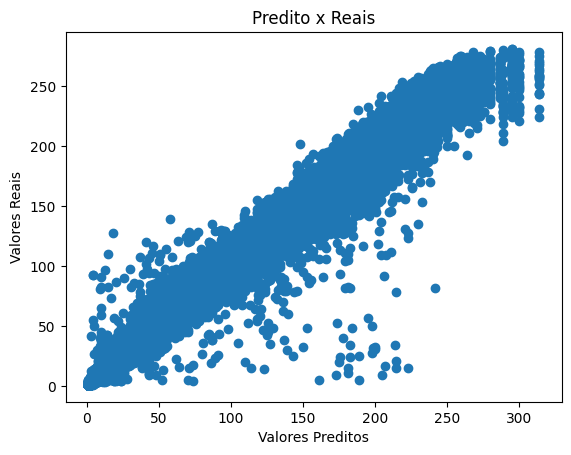

In [77]:
plt.scatter(x = teste["Calories"].to_numpy(), y = Y_pred)

plt.title("Predito x Reais")
plt.xlabel("Valores Preditos")
plt.ylabel("Valores Reais")


A partir do gráfico de valores preditos versus valores reais, observa-se que o modelo conseguiu capturar adequadamente a relação entre as variáveis, apresentando boa aderência à diagonal ao longo da maior parte do intervalo dos dados, o que indica um bom ajuste global.

Para a obtenção de resultados ainda melhores, duas direções principais se mostram promissoras: a utilização de uma fração maior do conjunto de dados no treinamento, visto que apenas cerca de 15% das observações foram utilizadas, e um maior investimento em engenharia de atributos, que tende a oferecer ganhos mais relevantes neste estágio do que apenas o aumento da complexidade do modelo.

# Predição Final 

Com o modelo final treinado e validado, vamos usá-lo para predição final.

In [68]:
dados_teste = pd.read_csv("data/test.csv")

dados_teste["Sex_Dummy"] = np.where(dados_teste["Sex"] == "male", 1, 0) # 1 P/ masculino, 0 P/ feminino
submission = dados_teste.drop(columns=["id", "Sex"])

Y_pred = np.exp(gb_model["predict"](submission.to_numpy()))

dados_teste["Calories"] = Y_pred

submission_file = dados_teste[["id", "Calories"]]

submission_file.head()

,id,Calories
0,750000,26.529425
1,750001,109.107833
2,750002,86.886350
3,750003,123.691553
4,750004,73.406039


Vamos salvar nossos dados de submissão.

In [70]:
submission_file.to_csv("data/submission_file.csv", index = False)

No Kaggle, conseguimos:

**Private Score:** 0.068
**Public Score:** 0.069

O modelo generalizou bem e não teve overfit!!